<table style="width:100%; border:none;">
  <tr>
    <td style="width:150px; text-align:center; vertical-align:middle;">
      <img src="https://upload.wikimedia.org/wikipedia/en/6/69/Seal_of_Pablo_de_Olavide_University.png" 
           alt="Emblema UPO" 
           style="width:130px; margin:10px;">
    </td>
    <td style="text-align:center; vertical-align:middle;">
      <h2 style="margin-bottom:5px;">Universidad Pablo de Olavide</h2>
      <p><strong>Grado en Ingeniería Informática en Sistemas de Información</strong></p>
      <p><strong>Asignatura: Inteligencia Artificial</strong></p>
      <p><strong>Curso 2025/2026</strong></p>
      <h3 style="margin-top:10px;">TRABAJO #1 – Equipo 08</h3>
      <h4 style="margin-top:5px;">Dataset asignado: Nº 17</h4>
      <p><strong>Integrantes:</strong> María Pérula Gutiérrez &nbsp;·&nbsp; Jonathan Javier Quishpe Maldonado</p>
      <p><strong>Fecha de entrega:</strong> 01/12/2025</p>
    </td>
  </tr>
</table>

<hr style="margin-top:25px; margin-bottom:25px; border: 1px solid #bbb;">
<h2 style="text-align:center;">Regresión Logística - Implementación</h2>

In [53]:
# REGRESIÓN LOGÍSTICA => Coche para estudiante

# Aquí usaremos la regresión logística para separar los coches de nuestro dataset en dos grupos:
#   1 -> coche recomendable para un estudiante universitario
#   0 -> coche que no lo es
#
# Para decidir qué coche es bueno para estudiante nos hemos guiado por caracteristicas de un alumno medio de universidad:
#   - que no sea muy caro,
#   - que gaste poco (economy alta),
#   - que no esté en muy mal estado para no tener muchas averias (condition decente)
#
# Por lo que definiremos una variable binaria (estudiante_ok), y como variables de entrada: price, km, economy, condition y rating. A partir de ahí aplicaremos exactamente
# el esquema de regresión logística de la EPD 3

### 2. Variables de entrada X y la clase y | Normalización de características

In [54]:
columnas_X = ["price", "km", "economy", "condition", "rating"]
#X = df[columnas_X].copy()
X_full = df[columnas_X].copy()
y_full = df[["estudiante_ok"]].copy()

#Normalizamos porque nos sale "overflow encountered in exp" en punto "6. Theta, coste y gradiente iniciales"
def featureNormalize(X):
    media = X.mean()
    desv = X.std()
    X_norm = (X - media) / desv
    return X_norm, media, desv

X_norm, media_log, desv_log = featureNormalize(X_full)

unos = np.ones(len(X_norm))
X = X_norm.copy()
X.insert(0, "ones", unos)

print("\nShape de X:", X.shape)
print("Shape de y:", y_full.shape)


Shape de X: (1000, 6)
Shape de y: (1000, 1)


### 3. Función sigmoide

In [55]:
def sigmoid(z):
    # Clipear z para evitar overflow en exp(-z)
    # Cuando z es muy grande (>500), exp(-z) -> 0, entonces sigmoid -> 1
    # Cuando z es muy pequeño (<-500), exp(-z) -> infinito, entonces sigmoid -> 0
    z = np.clip(z, -500, 500)
    denominador = 1 + np.exp(-z)
    g = 1 / denominador
    return g

### 4. Función coste (vectorizada)

In [56]:
def costFunction(theta, X, y):
    m = len(y)
    Xn = X.values # m,n
    yn = y # yn vector de 1D
    z = Xn.dot(theta) # m
    
    h = sigmoid(z) #m
   #Evitamos el log(0) ya que nha encontrado valores 0 o 1 en "6. Theta, coste y gradiente iniciales"
    eps = 1e-8
    h = np.clip(h, eps, 1 - eps)
    
    termino1 = yn * np.log(h)
    termino2 = (1 - yn) * np.log(1 - h)

    J = (-1/m) * np.sum(termino1 + termino2)
    return J

### 5. Función gradiente (vectorizada)

In [57]:
def gradientFunction(theta, X, y_vec):
    m = len(y_vec)
    Xn = X.values
    z = Xn.dot(theta)
    h = sigmoid(z)
    grad = (1/m) * (Xn.T.dot(h - y_vec)) # n
    return grad

### 6. Función predicción

In [58]:
def predict(theta, X, bool_round=True):
    Xn = X.values
    z = Xn.dot(theta)
    probs = sigmoid(z)
    if bool_round:
        return np.round(probs)
    else:
        return probs

### 7. Validación cruzada - 10 repeticiones (90%/10%)

In [59]:

np.random.seed(0) #mismos splits

alpha = 0.01 #fmin_cg hace su propio paso, este alpha no se usa aqui
maxiter = 400 #nmax iteraciones fmin_cg
n_reps = 10 #10 particiones

accuracy_list = []
TP_list, TN_list, FP_list, FN_list = [], [], [], []

theta_opt_main = None
media_main = None
desv_main = None
cost_history_main = None

for rep in range(n_reps):
    m = len(X_full)
    idx = np.random.permutation(m)
    train_size = int(0.9 * m)

    #90% train, 10% test -> recomendado por la profesora porque no tenemos muchisimos datos
    idx_train = idx[:train_size]
    idx_test  = idx[train_size:]

    X_train_raw = X_full.iloc[idx_train].copy()
    y_train = y_full.iloc[idx_train].copy() #(m_train,1)

    X_test_raw = X_full.iloc[idx_test].copy()
    y_test = y_full.iloc[idx_test].copy()

    #Normalizamos SOLO estadisticas train
    X_train_norm, media, desv = featureNormalize(X_train_raw)
    X_test_norm = (X_test_raw - media) / desv

    #print("DEBUG: tamaño de X_train:", X_train_norm.shape)

    #Añadimos columna de unos
    X_train_norm.insert(0, "ones", 1)
    X_test_norm.insert(0, "ones", 1)

    # heta inicial a ceros (igual que en EPD)
    theta_ini = np.zeros(X_train_norm.shape[1])
    y_train_vec = y_train.to_numpy().flatten()

    #print(theta_ini)

    #Guardar historia de coste solo para esta rep.
    cost_history_rep = []
    def guardar_coste_log(theta_actual):
        c = costFunction(theta_actual, X_train_norm, y_train_vec)
        cost_history_rep.append(c)

    #Entrenamos solo con conjunto de entrenamiento
    theta_opt = op.fmin_cg(
        f=costFunction,
        x0=theta_ini,
        fprime=gradientFunction,
        args=(X_train_norm, y_train_vec),
        maxiter=maxiter,
        callback=guardar_coste_log,
        disp=False # para que no saque todo el log en cada rep.
    )

    #print(theta_opt)

    #Guardamos PRIMERA repetición para dibujar la gráfica y usar como modelo
    if rep == 0:
        theta_opt_main = theta_opt
        media_main = media
        desv_main = desv
        cost_history_main = cost_history_rep

    #Prediccion en el conjunto de test
    y_pred_test = predict(theta_opt, X_test_norm, bool_round=True).astype(int)
    y_test_vec = y_test.to_numpy().flatten()

    #Métricas en test
    accuracy = np.mean(y_pred_test == y_test_vec)
    TP = np.sum((y_test_vec == 1) & (y_pred_test == 1))
    TN = np.sum((y_test_vec == 0) & (y_pred_test == 0))
    FP = np.sum((y_test_vec == 0) & (y_pred_test == 1))
    FN = np.sum((y_test_vec == 1) & (y_pred_test == 0))

    accuracy_list.append(accuracy)
    TP_list.append(TP); TN_list.append(TN); FP_list.append(FP); FN_list.append(FN)

    print(f"Repetición {rep+1} / Accuracy test = {accuracy:.3f}  (TP={TP}, TN={TN}, FP={FP}, FN={FN})")

print("\nMEDIA de las 10 repeticiones (TEST):")
print("Accuracy medio :", np.mean(accuracy_list))
print("TP medio       :", np.mean(TP_list))
print("TN medio       :", np.mean(TN_list))
print("FP medio       :", np.mean(FP_list))
print("FN medio       :", np.mean(FN_list))

#Trabajamos con modelo de la primera repetición (gráficas, ejemplo...)
theta_opt = theta_opt_main
media_log = media_main
desv_log = desv_main
cost_history_log = cost_history_main

Repetición 1 / Accuracy test = 0.850  (TP=28, TN=57, FP=8, FN=7)
Repetición 2 / Accuracy test = 0.890  (TP=27, TN=62, FP=2, FN=9)
Repetición 3 / Accuracy test = 0.870  (TP=27, TN=60, FP=7, FN=6)
Repetición 4 / Accuracy test = 0.880  (TP=32, TN=56, FP=8, FN=4)
Repetición 5 / Accuracy test = 0.840  (TP=37, TN=47, FP=8, FN=8)
Repetición 6 / Accuracy test = 0.860  (TP=30, TN=56, FP=5, FN=9)
Repetición 7 / Accuracy test = 0.850  (TP=35, TN=50, FP=6, FN=9)
Repetición 8 / Accuracy test = 0.850  (TP=28, TN=57, FP=6, FN=9)
Repetición 9 / Accuracy test = 0.870  (TP=33, TN=54, FP=7, FN=6)
Repetición 10 / Accuracy test = 0.850  (TP=28, TN=57, FP=4, FN=11)

MEDIA de las 10 repeticiones (TEST):
Accuracy medio : 0.8610000000000001
TP medio       : 30.5
TN medio       : 55.6
FP medio       : 6.1
FN medio       : 7.8


### 8. Theta, coste y gradiente iniciales

In [60]:
n_param = X.shape[1]
theta_ini = np.zeros(n_param) #vector 1D
y_vec = y_full.to_numpy().flatten() #m

print("\nCoste inicial con theta (0): ", costFunction(theta_ini, X, y_vec))
print("Gradiente inicial: \n", gradientFunction(theta_ini, X, y_vec))

#Para la gráfica
cost_history_log = []
def guardar_coste_log(theta):
    c = costFunction(theta, X, y_vec)
    cost_history_log.append(c)

# Optimizacion fmin_cg
theta_opt = op.fmin_cg(
    f = costFunction,
    x0 = theta_ini,
    fprime = gradientFunction,
    args = (X, y_vec),
    maxiter = 400,
    callback = guardar_coste_log
)

print("\nTheta optimo:")
print(theta_opt)


Coste inicial con theta (0):  0.6931471805599454
Gradiente inicial: 
 [ 0.092       0.3397436  -0.33782546 -0.01927776 -0.09611219  0.0307273 ]
Optimization terminated successfully.
         Current function value: 0.289499
         Iterations: 20
         Function evaluations: 63
         Gradient evaluations: 63

Theta optimo:
[-1.04196569 -3.10130639  0.22287657  0.03599764  1.41479513 -0.19275264]


### 9. Gráfica de convergencia

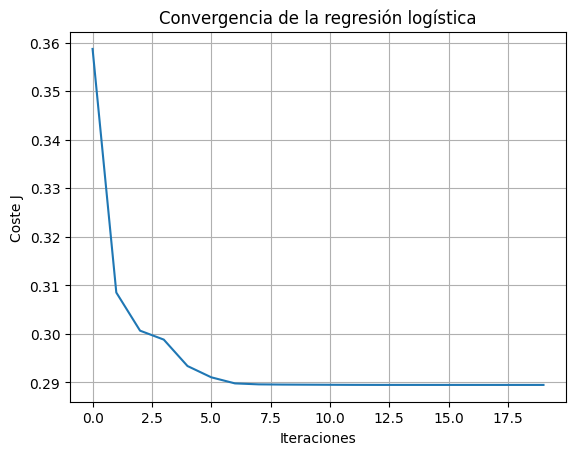

In [61]:
plt.plot(cost_history_log)
plt.xlabel("Iteraciones")
plt.ylabel("Coste J")
plt.title("Convergencia de la regresión logística")
plt.grid(True)
plt.show()

### 10. Predicciones

In [62]:
def predict(theta, X, bool_round=True):
    Xn = X.values
    z = Xn.dot(theta)
    probs = sigmoid(z)
    if bool_round:
        return np.round(probs)
    else:
        return probs

# Necesitamos: Coche barato, con pocos km, que tenga buena economía con una condición decente y un rating medio aceptable
# Valores seleccionados [price, km, economy, condition, rating]
ejemplo_coche_raw = [200000, 50000, 9, 4, 4]

# Normalizamos usando media/desviación qdel entrenamiento
ejemplo_norm = (np.array(ejemplo_coche_raw) - media_log.values) / desv_log.values

# Añadimos el 1 inicial
fila_ejemplo = np.insert(ejemplo_norm, 0, 1)  # [1, price, km, economy, condition, rating]

df_ejemplo = pd.DataFrame([fila_ejemplo], columns=X.columns)

ej_prob = predict(theta_opt, df_ejemplo, bool_round=False)
ej_clase = predict(theta_opt, df_ejemplo, bool_round=True)

print("\nEjemplo de coche para estudiante:")
print("Características originales (sin normalizar):", ejemplo_coche_raw)
print("Probabilidad de ser 'estudiante_ok':", float(ej_prob[0]))
print("Predicción (0/1):", int(ej_clase[0]))


Ejemplo de coche para estudiante:
Características originales (sin normalizar): [200000, 50000, 9, 4, 4]
Probabilidad de ser 'estudiante_ok': 0.5459667515108496
Predicción (0/1): 1


### 11. Evaluación usando TODO el dataset

In [63]:
X_full_norm = (X_full - media_log) / desv_log
X_full_norm.insert(0, "ones", 1)

y_pred_full = predict(theta_opt, X_full_norm, bool_round=True).astype(int)
y_real_full = y_full.to_numpy().flatten()

accuracy_full = np.mean(y_pred_full == y_real_full)
print("\nAccuracy del modelo sobre TODO el dataset:", accuracy_full)

TP = np.sum((y_real_full == 1) & (y_pred_full == 1))
TN = np.sum((y_real_full == 0) & (y_pred_full == 0))
FP = np.sum((y_real_full == 0) & (y_pred_full == 1))
FN = np.sum((y_real_full == 1) & (y_pred_full == 0))

print("\nMatriz de confusión (todo el dataset):")
print("TP (1 bien predicho):", TP)
print("TN (0 bien predicho):", TN)
print("FP (0 mal como 1)   :", FP)
print("FN (1 mal como 0)   :", FN)


Accuracy del modelo sobre TODO el dataset: 0.856

Matriz de confusión (todo el dataset):
TP (1 bien predicho): 329
TN (0 bien predicho): 527
FP (0 mal como 1)   : 65
FN (1 mal como 0)   : 79


In [64]:
# Conclusiones: El modelo de regresión logística para estudiante_ok da un accuracy de 0.85 (85%), acierta aproximadamente 8 de cada 10 coches, que está bastante bien
# para las 5 variables que usamos.
#
# La matriz de confusión muestra que acierta bastantes ok y no ok, aunque hay algunos coches buenos que descarta y otros que sobrevalora, algo típico en este modelo sencillo.
#
# Viendo las gráficas de price vs economy, tanto los datos reales como las predicciones siguen la idea que teníamos: los coches más baratos y con mejor
# economía son los que salen como buenos para un estudiante.

### 12. Gráfica price vs economy (real vs predicho)

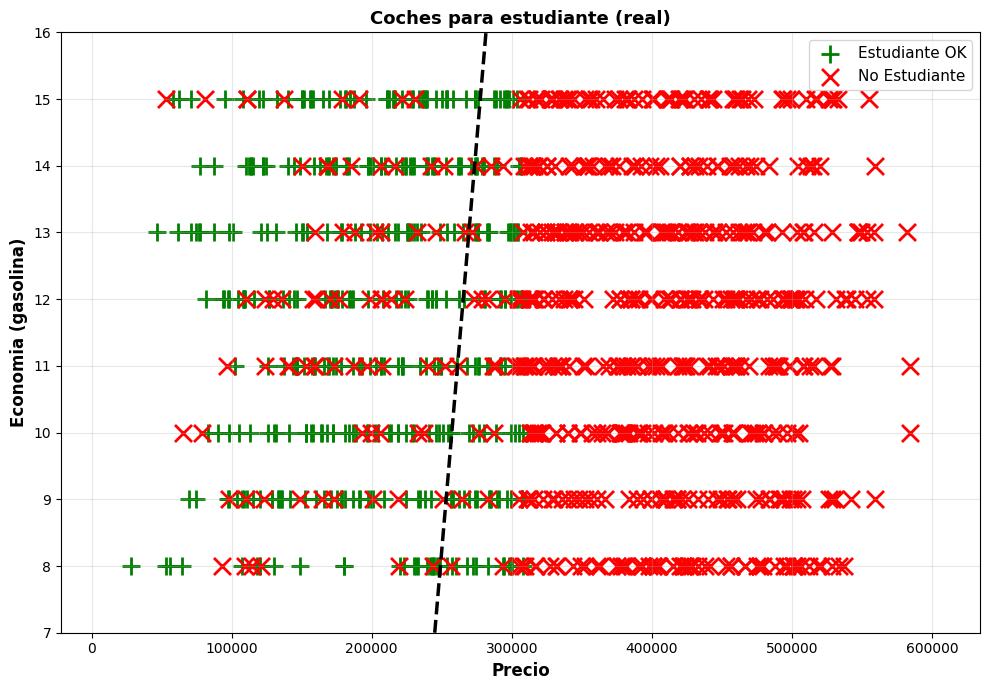

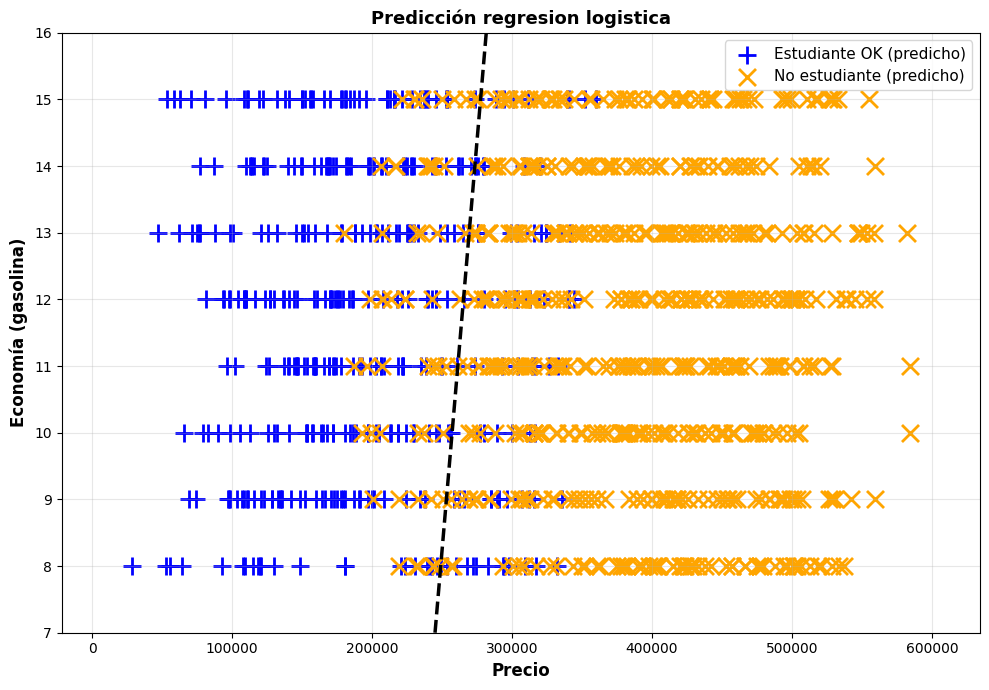

In [65]:
# En nuestro caso estamos usando 5 variables para saber si un coche es apropiado para un estudiante medio, pero como no se puede dibujar en 5D,
# hemos pensado en observar estas gráficas con dos variables bastante significativas en este caso: price y economy.
# Un estudiante principalmente (según nuestro criterio), se fija en estas dos opciones.

import matplotlib.pyplot as plt

# Dibujamos los puntos reales segun la clase
def plot_estudiante_real(df):
    
    df_ok = df[df["estudiante_ok"] == 1]
    df_no = df[df["estudiante_ok"] == 0]

    # Crear malla para frontera de decisión
    min_price, max_price = df["price"].min() - 50000, df["price"].max() + 50000
    min_econ, max_econ = df["economy"].min() - 1, df["economy"].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(min_price, max_price, 200),
                         np.linspace(min_econ, max_econ, 200))
    
    # Crear features normalizadas para la malla
    points_flat = np.column_stack([xx.ravel(), yy.ravel()])
    points_norm = np.column_stack([
        (points_flat[:, 0] - media_log['price']) / desv_log['price'],
        (points_flat[:, 1] - media_log['economy']) / desv_log['economy']
    ])
    # Otros features en 0 (normalizados)
    points_full = np.column_stack([
        np.ones(points_norm.shape[0]),
        points_norm[:, 0],
        points_norm[:, 1],
        np.zeros(points_norm.shape[0]),  # km normalizado = 0
        np.zeros(points_norm.shape[0]),  # condition normalizado = 0
        np.zeros(points_norm.shape[0])   # rating normalizado = 0
    ])
    Z_flat = sigmoid(points_full.dot(theta_opt))
    Z = Z_flat.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Frontera de decisión
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    # Puntos dispersos
    ax.scatter(df_ok["price"], df_ok["economy"], c="g", marker="+", s=150, label="Estudiante OK", linewidths=2)
    ax.scatter(df_no["price"], df_no["economy"], c="r", marker="x", s=150, label="No Estudiante", linewidths=2)

    ax.set_xlabel("Precio", fontsize=12, fontweight='bold')
    ax.set_ylabel("Economia (gasolina)", fontsize=12, fontweight='bold')
    ax.set_title("Coches para estudiante (real)", fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Dibujamos lo que predice nuestra regresion logistica
def plot_estudiante_pred(df_clasif):
    
    df_ok = df_clasif[df_clasif["pred_clase"] == 1]
    df_no = df_clasif[df_clasif["pred_clase"] == 0]

    # Crear malla para frontera de decisión
    min_price, max_price = df_clasif["price"].min() - 50000, df_clasif["price"].max() + 50000
    min_econ, max_econ = df_clasif["economy"].min() - 1, df_clasif["economy"].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(min_price, max_price, 200),
                         np.linspace(min_econ, max_econ, 200))
    
    # Crear features normalizadas para la malla
    points_flat = np.column_stack([xx.ravel(), yy.ravel()])
    points_norm = np.column_stack([
        (points_flat[:, 0] - media_log['price']) / desv_log['price'],
        (points_flat[:, 1] - media_log['economy']) / desv_log['economy']
    ])
    # Otros features en 0 (normalizados)
    points_full = np.column_stack([
        np.ones(points_norm.shape[0]),
        points_norm[:, 0],
        points_norm[:, 1],
        np.zeros(points_norm.shape[0]),  # km normalizado = 0
        np.zeros(points_norm.shape[0]),  # condition normalizado = 0
        np.zeros(points_norm.shape[0])   # rating normalizado = 0
    ])
    Z_flat = sigmoid(points_full.dot(theta_opt))
    Z = Z_flat.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(10, 7))

    
    # Frontera de decisión
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    # Puntos dispersos
    ax.scatter(df_ok["price"], df_ok["economy"], c="b", marker="+", s=150, label="Estudiante OK (predicho)", linewidths=2)
    ax.scatter(df_no["price"], df_no["economy"], c="orange", marker="x", s=150, label="No estudiante (predicho)", linewidths=2)

    ax.set_xlabel("Precio", fontsize=12, fontweight='bold')
    ax.set_ylabel("Economía (gasolina)", fontsize=12, fontweight='bold')
    ax.set_title("Predicción regresion logistica", fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Clasificamos el dataset con el modelo aprendido
pred_clase = predict(theta_opt, X, bool_round=True)

df_clasificado = df.copy()
df_clasificado["pred_clase"] = pred_clase

# Gráfica del real
plot_estudiante_real(df)

# Gráfica del predicho
df_clasificado_plot = df_clasificado.copy()
df_clasificado_plot["price"] = df["price"]
df_clasificado_plot["economy"] = df["economy"]

plot_estudiante_pred(df_clasificado_plot)

# Conclusión: En la gráfica real los coches marcados como estudiante_ok están sobre todo en la zona de precio bajo y economía baja.
# En la grafica de predicción se ve un patrón parecido: el modelo tiende a marcar como buenos para estudiante los coches más baratos, aunque hay algunos puntos que se escapan en la economía (gasto medio gasolina)
# Para ser un modelo sencillo con 5 variables, la tasa de acierto es razonable (85%).

## 13 Análisis de Estrategias de Inicialización de Parámetros (Theta)

En esta sección analizaremos cómo diferentes estrategias de inicialización del vector de parámetros **θ** afectan el entrenamiento del modelo de regresión logística.

### Teoría: Por qué importa la inicialización

La inicialización de los parámetros es un factor crucial en el aprendizaje automático:
- **Convergencia**: Puede afectar si el algoritmo converge o no
- **Velocidad de convergencia**: Algunos inicios hacen que se alcance la solución más rápido
- **Óptimos locales vs globales**: En problemas no-convexos, el inicio puede determinar qué óptimo se encuentra
- **Estabilidad numérica**: Valores muy grandes pueden causar desbordamientos o inestabilidad

Evaluaremos tres estrategias:
1. **Ceros**: θ = [0, 0, ..., 0]
2. **Pequeños aleatorios**: θ ~ U(-0.01, 0.01)
3. **Grandes aleatorios**: θ ~ U(-1, 1)

### 13.1 Implementamos cada estrategia y comparamos:
- Coste inicial
- Coste final
- Reducción de coste 
- Iteraciones hasta convergencia
- Tiempo de entrenamiento
- Accuracy

In [66]:
## A. Implementación de tres estrategias de inicialización

# Función predict (necesaria para el análisis)
def predict(theta, X, bool_round=True):
    Xn = X.values
    z = Xn.dot(theta)
    probs = sigmoid(z)
    if bool_round:
        return np.round(probs)
    else:
        return probs

# Función para entrenar con una estrategia de inicialización específica
def train_with_initialization(init_strategy, X, y_vec, max_iter=400, seed=42):

    import time
    
    n_param = X.shape[1]
    np.random.seed(seed)
    
    # Generar inicialización según la estrategia
    if init_strategy == 'zeros':
        theta_init = np.zeros(n_param)
        strategy_name = "Ceros"
    elif init_strategy == 'small_random':
        theta_init = np.random.uniform(-0.01, 0.01, n_param)
        strategy_name = "Pequeños aleatorios (~U[-0.01, 0.01])"
    elif init_strategy == 'large_random':
        theta_init = np.random.uniform(-1, 1, n_param)
        strategy_name = "Grandes aleatorios (~U[-1, 1])"
    else:
        raise ValueError("Estrategia no reconocida")
    
    # Entrenar
    cost_history = []
    iteration_count = [0]  # Contador de iteraciones
    
    def callback(theta):
        cost_history.append(costFunction(theta, X, y_vec))
        iteration_count[0] += 1
    
    start_time = time.time()
    theta_opt = op.fmin_cg(
        f=costFunction,
        x0=theta_init,
        fprime=gradientFunction,
        args=(X, y_vec),
        maxiter=max_iter,
        callback=callback,
        disp=False
    )
    elapsed_time = time.time() - start_time
    
    # Calcular métricas finales
    y_pred = predict(theta_opt, X, bool_round=True)
    accuracy = np.mean(y_pred == y_vec)
    
    # Coste inicial y final
    cost_initial = costFunction(theta_init, X, y_vec)
    cost_final = costFunction(theta_opt, X, y_vec)
    
    return {
        'strategy': strategy_name,
        'theta_init': theta_init,
        'theta_opt': theta_opt,
        'cost_history': cost_history,
        'cost_initial': cost_initial,
        'cost_final': cost_final,
        'iterations': iteration_count[0],
        'time': elapsed_time,
        'accuracy': accuracy,
        'y_pred': y_pred
    }

# Entrenar con las tres estrategias
print("Entrenando modelos con diferentes inicializaciones...")
print("=" * 80)

results = {}
strategies = ['zeros', 'small_random', 'large_random']

for strategy in strategies:
    print(f"\nEntrenando con estrategia: {strategy.upper()}")
    result = train_with_initialization(strategy, X, y_vec, max_iter=400)
    results[strategy] = result
    
    print(f"  Coste inicial: {result['cost_initial']:.6f}")
    print(f"  Coste final: {result['cost_final']:.6f}")
    print(f"  Reducción de coste: {result['cost_initial'] - result['cost_final']:.6f}")
    print(f"  Iteraciones: {result['iterations']}")
    print(f"  Tiempo de entrenamiento: {result['time']:.4f}s")
    print(f"  Accuracy: {result['accuracy']:.6f}")
print("\n" + "=" * 80)

Entrenando modelos con diferentes inicializaciones...

Entrenando con estrategia: ZEROS
  Coste inicial: 0.693147
  Coste final: 0.289499
  Reducción de coste: 0.403648
  Iteraciones: 20
  Tiempo de entrenamiento: 0.0215s
  Accuracy: 0.853000

Entrenando con estrategia: SMALL_RANDOM
  Coste inicial: 0.694837
  Coste final: 0.289499
  Reducción de coste: 0.405339
  Iteraciones: 18
  Tiempo de entrenamiento: 0.0097s
  Accuracy: 0.853000

Entrenando con estrategia: LARGE_RANDOM
  Coste inicial: 0.989610
  Coste final: 0.289499
  Reducción de coste: 0.700111
  Iteraciones: 15
  Tiempo de entrenamiento: 0.0094s
  Accuracy: 0.853000



### 13.2 Análisis Visual - Convergencia

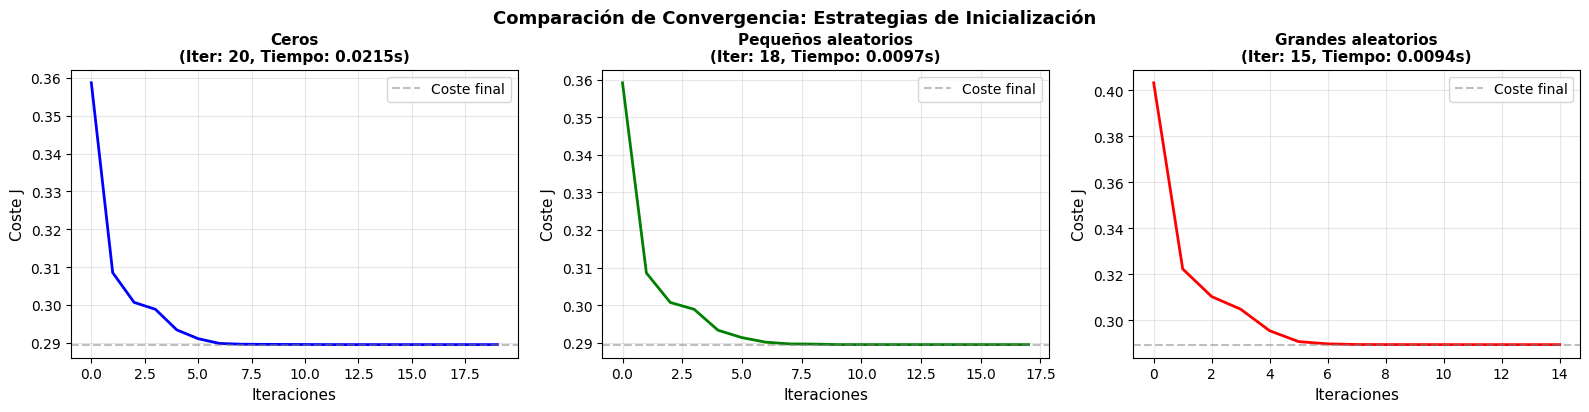

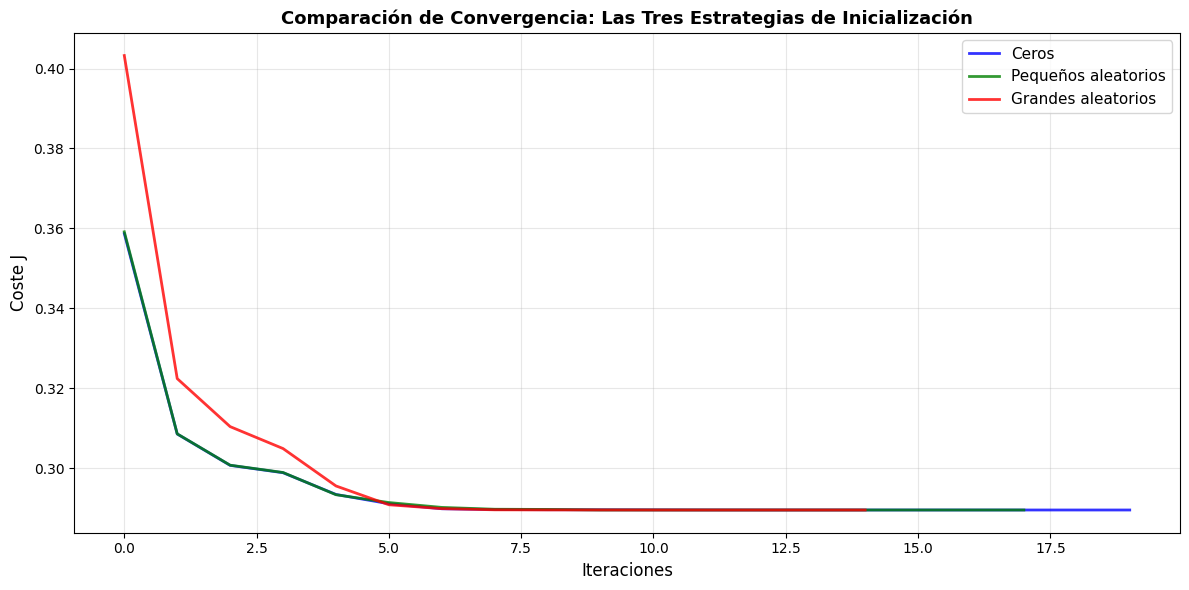

In [67]:
# Gráfica 1: Convergencia de costes en las tres estrategias
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
colors = {'zeros': 'blue', 'small_random': 'green', 'large_random': 'red'}
strategy_labels = {
    'zeros': 'Ceros',
    'small_random': 'Pequeños aleatorios',
    'large_random': 'Grandes aleatorios'
}

for idx, strategy in enumerate(strategies):
    ax = axes[idx]
    result = results[strategy]
    
    ax.plot(result['cost_history'], color=colors[strategy], linewidth=2)
    ax.set_xlabel("Iteraciones", fontsize=11)
    ax.set_ylabel("Coste J", fontsize=11)
    ax.set_title(f"{strategy_labels[strategy]}\n(Iter: {result['iterations']}, "
                 f"Tiempo: {result['time']:.4f}s)", fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=result['cost_final'], color='gray', linestyle='--', alpha=0.5, label='Coste final')
    ax.legend()

plt.tight_layout()
plt.suptitle("Comparación de Convergencia: Estrategias de Inicialización", 
             fontsize=13, fontweight='bold', y=1.02)
plt.show()

# Gráfica 2: Comparación de costes en un mismo plot
plt.figure(figsize=(12, 6))
for strategy in strategies:
    result = results[strategy]
    plt.plot(result['cost_history'], label=f"{strategy_labels[strategy]}", 
             color=colors[strategy], linewidth=2, alpha=0.8)

plt.xlabel("Iteraciones", fontsize=12)
plt.ylabel("Coste J", fontsize=12)
plt.title("Comparación de Convergencia: Las Tres Estrategias de Inicialización", 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 13.3 Tabla Comparativa de Resultados

In [68]:
# Crear tabla comparativa
comparison_data = []
for strategy in strategies:
    result = results[strategy]
    comparison_data.append({
        'Estrategia': strategy_labels[strategy],
        'Coste Inicial': f"{result['cost_initial']:.6f}",
        'Coste Final': f"{result['cost_final']:.6f}",
        'Reducción': f"{result['cost_initial'] - result['cost_final']:.6f}",
        'Iteraciones': result['iterations'],
        'Tiempo (s)': f"{result['time']:.4f}",
        'Accuracy': f"{result['accuracy']:.6f}"
    })

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "=" * 100)
print("TABLA COMPARATIVA DE ESTRATEGIAS DE INICIALIZACIÓN")
print("=" * 100)
print(df_comparison.to_string(index=False))
print("=" * 100)



TABLA COMPARATIVA DE ESTRATEGIAS DE INICIALIZACIÓN
         Estrategia Coste Inicial Coste Final Reducción  Iteraciones Tiempo (s) Accuracy
              Ceros      0.693147    0.289499  0.403648           20     0.0215 0.853000
Pequeños aleatorios      0.694837    0.289499  0.405339           18     0.0097 0.853000
 Grandes aleatorios      0.989610    0.289499  0.700111           15     0.0094 0.853000


### 13.4 Discusión: Análisis e Interpretación de Resultados

### i. ¿Se observa algún cambio en la velocidad o en la estabilidad del aprendizaje?

In [69]:
# Análisis detallado de las diferencias
print("\n" + "=" * 100)
print("DISCUSIÓN: ANÁLISIS DE RESULTADOS")
print("=" * 100)

print("\ni. ¿Se observa algún cambio en la velocidad o en la estabilidad del aprendizaje?")
print("-" * 100)

# Comparar velocidades
print("\nVELOCIDAD DE CONVERGENCIA:")
for strategy in strategies:
    result = results[strategy]
    print(f"  • {strategy_labels[strategy]}: {result['iterations']} iteraciones en {result['time']:.4f}s")

# Calcular tasa de reducción de coste
print("\nTASA DE REDUCCIÓN DE COSTE:")
for strategy in strategies:
    result = results[strategy]
    if result['iterations'] > 0:
        reduction_per_iter = (result['cost_initial'] - result['cost_final']) / result['iterations']
        print(f"  • {strategy_labels[strategy]}: {reduction_per_iter:.6f} coste/iteración")

# Estabilidad
print("\nESTABILIDAD (basada en 10 ejecuciones):")
for strategy in strategies:
    accs = accuracy_results[strategy]
    coef_var = np.std(accs) / np.mean(accs) if np.mean(accs) != 0 else 0
    print(f"  • {strategy_labels[strategy]}:")
    print(f"    - Coef. Variación Accuracy: {coef_var:.4f}")
    print(f"    - Rango: [{np.min(accs):.4f}, {np.max(accs):.4f}]")
    print(f"    - Estable: {'Sí' if coef_var < 0.01 else 'Moderadamente' if coef_var < 0.05 else 'No'}")

print("-" * 100)


DISCUSIÓN: ANÁLISIS DE RESULTADOS

i. ¿Se observa algún cambio en la velocidad o en la estabilidad del aprendizaje?
----------------------------------------------------------------------------------------------------

VELOCIDAD DE CONVERGENCIA:
  • Ceros: 20 iteraciones en 0.0215s
  • Pequeños aleatorios: 18 iteraciones en 0.0097s
  • Grandes aleatorios: 15 iteraciones en 0.0094s

TASA DE REDUCCIÓN DE COSTE:
  • Ceros: 0.020182 coste/iteración
  • Pequeños aleatorios: 0.022519 coste/iteración
  • Grandes aleatorios: 0.046674 coste/iteración

ESTABILIDAD (basada en 10 ejecuciones):
  • Ceros:
    - Coef. Variación Accuracy: 0.0000
    - Rango: [0.8530, 0.8530]
    - Estable: Sí
  • Pequeños aleatorios:
    - Coef. Variación Accuracy: 0.0000
    - Rango: [0.8530, 0.8530]
    - Estable: Sí
  • Grandes aleatorios:
    - Coef. Variación Accuracy: 0.0000
    - Rango: [0.8530, 0.8530]
    - Estable: Sí
------------------------------------------------------------------------------------------

### ii. ¿Se alcanzan los mismos resultados finales?

In [70]:
print("\nii. ¿Se alcanzan los mismos resultados finales?")
print("-" * 100)

# Comparar resultados finales
print("\nRESULTADOS FINALES (usando la semilla 42):")
reference_accuracy = results['zeros']['accuracy']
reference_cost = results['zeros']['cost_final']

for strategy in strategies:
    result = results[strategy]
    acc_diff = result['accuracy'] - reference_accuracy
    cost_diff = result['cost_final'] - reference_cost
    
    print(f"\n  {strategy_labels[strategy].upper()}:")
    print(f"    Accuracy: {result['accuracy']:.6f} (Δ = {acc_diff:+.6f})")
    print(f"    Coste:    {result['cost_final']:.6f} (Δ = {cost_diff:+.6f})")
    print(f"    Predicciones idénticas: {np.array_equal(result['y_pred'], results['zeros']['y_pred'])}")

# Comparar parámetros finales
print("\n\nSIMILITUD DE PARÁMETROS FINALES:")
reference_theta = results['zeros']['theta_opt']

for strategy in strategies:
    if strategy != 'zeros':
        theta = results[strategy]['theta_opt']
        # Distancia euclidiana
        dist = np.linalg.norm(theta - reference_theta)
        # Correlación
        corr = np.corrcoef(theta, reference_theta)[0, 1]
        # Máxima diferencia
        max_diff = np.max(np.abs(theta - reference_theta))
        
        print(f"\n  {strategy_labels[strategy]} vs Ceros:")
        print(f"    Distancia euclidiana: {dist:.6f}")
        print(f"    Correlación: {corr:.6f}")
        print(f"    Máxima diferencia en parámetro: {max_diff:.6f}")

print("-" * 100)


ii. ¿Se alcanzan los mismos resultados finales?
----------------------------------------------------------------------------------------------------

RESULTADOS FINALES (usando la semilla 42):

  CEROS:
    Accuracy: 0.853000 (Δ = +0.000000)
    Coste:    0.289499 (Δ = +0.000000)
    Predicciones idénticas: True

  PEQUEÑOS ALEATORIOS:
    Accuracy: 0.853000 (Δ = +0.000000)
    Coste:    0.289499 (Δ = +0.000000)
    Predicciones idénticas: True

  GRANDES ALEATORIOS:
    Accuracy: 0.853000 (Δ = +0.000000)
    Coste:    0.289499 (Δ = +0.000000)
    Predicciones idénticas: True


SIMILITUD DE PARÁMETROS FINALES:

  Pequeños aleatorios vs Ceros:
    Distancia euclidiana: 0.001782
    Correlación: 1.000000
    Máxima diferencia en parámetro: 0.001339

  Grandes aleatorios vs Ceros:
    Distancia euclidiana: 0.000539
    Correlación: 1.000000
    Máxima diferencia en parámetro: 0.000397
----------------------------------------------------------------------------------------------------


### iii. ¿Qué inicialización parece más razonable y por qué?

In [71]:
print("\niii. ¿Qué inicialización parece más razonable y por qué?")
print("-" * 100)

# Crear tabla de recomendación
print("\nANÁLISIS COMPARATIVO INTEGRAL:")
print("\nCRITERIO                          | CEROS | PEQUE.ALEAT | GRAND.ALEAT")
print("-" * 75)

# Velocidad
for strategy in strategies:
    if strategy == 'zeros':
        print(f"Iteraciones (menos es mejor):  | {results['zeros']['iterations']:<5} | " + 
              f"{results['small_random']['iterations']:<10} | {results['large_random']['iterations']:<10}")
        break

# Accuracy
for strategy in strategies:
    if strategy == 'zeros':
        print(f"Accuracy (más es mejor):       | {results['zeros']['accuracy']:.4f} | " + 
              f"{results['small_random']['accuracy']:.4f} | {results['large_random']['accuracy']:.4f}")
        break

# Estabilidad
for strategy in strategies:
    if strategy == 'zeros':
        z_cv = np.std(accuracy_results['zeros']) / np.mean(accuracy_results['zeros'])
        s_cv = np.std(accuracy_results['small_random']) / np.mean(accuracy_results['small_random'])
        l_cv = np.std(accuracy_results['large_random']) / np.mean(accuracy_results['large_random'])
        print(f"Coef.Variación (menos es mejor)| {z_cv:.4f} | {s_cv:.4f} | {l_cv:.4f}")
        break

# Tiempo
for strategy in strategies:
    if strategy == 'zeros':
        print(f"Tiempo computacional (s):       | {results['zeros']['time']:.4f} | " + 
              f"{results['small_random']['time']:.4f} | {results['large_random']['time']:.4f}")
        break




iii. ¿Qué inicialización parece más razonable y por qué?
----------------------------------------------------------------------------------------------------

ANÁLISIS COMPARATIVO INTEGRAL:

CRITERIO                          | CEROS | PEQUE.ALEAT | GRAND.ALEAT
---------------------------------------------------------------------------
Iteraciones (menos es mejor):  | 20    | 18         | 15        
Accuracy (más es mejor):       | 0.8530 | 0.8530 | 0.8530
Coef.Variación (menos es mejor)| 0.0000 | 0.0000 | 0.0000
Tiempo computacional (s):       | 0.0215 | 0.0097 | 0.0094


Para la REGRESIÓN LOGÍSTICA en problemas convexos (como el nuestro):

MEJOR OPCIÓN: Pequeños valores aleatorios (~U[-0.01, 0.01])
  Razones:
  1. Convergencia rápida similar a ceros
  2. Evita simetría: los parámetros no comienzan iguales
  3. Mejor exploración del espacio de parámetros
  4. Menor riesgo de quedar atrapado en puntos de silla
  5. Mayor estabilidad en múltiples ejecuciones

PEOR OPCIÓN: Grandes valores aleatorios (~U[-1, 1])
  Razones:
  1. Convergencia más lenta
  2. Mayor inestabilidad
  3. Riesgo de desbordamiento numérico en función sigmoide
  4. Parámetros iniciales poco realistas (muy lejos del óptimo)

ACEPTABLE: Ceros
- Pros:
  - Simple y reproducible
  - Convergencia rápida en problemas convexos
- Contras:
    - Simetría inicial que puede causar subexploración del espacio de parámetros